In [3]:
import os 
import numpy as np 
import pandas as pd 
import scanpy as sc
import anndata
import copy
import desc
import matplotlib.pyplot as pl
# following line ensures the pl plots inline 
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error

In [28]:
print(os.listdir('.'))

['GSE173947_home_cage_umi_counts.csv', 'GSE173947_home_cage_mOSN_iOSN.h5ad', 'sinfo-requirements.txt', 'GSE173947_home_cage_immature_umi_counts.csv', '1_scanpy.ipynb', 'GSE173947_home_cage_matureOSN.h5ad', '.ipynb_checkpoints', 'GSE173947_home_cage_metadata.csv', 'GSE173947_home_cage_immature_metadata.csv']


In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_versions()
sc.logging.print_header()
results_file = './write/GSE173947_home_cage_umi_counts.h5ad'
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.21.5 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.1 python-igraph==0.9.9 pynndescent==0.5.5


In [65]:
# reads in csv umi_counts data as anndata 
mOSN_adata = anndata.read_csv('./files/GSE173947_home_cage_umi_counts.csv')
mOSN_adata.raw = mOSN_adata
mOSN_adata.obs['cell_type'] = 'mOSN'
iOSN_adata = anndata.read_csv('./files/GSE173947_home_cage_immature_umi_counts.csv')
iOSN_adata.raw = iOSN_adata
iOSN_adata.obs['cell_type'] = 'iOSN'
adata = anndata.concat([mOSN_adata, iOSN_adata])

In [185]:
# revert back to original data 
adata = adata.raw.to_adata() 
adata.raw = adata

In [186]:
adata.var['mt'] = adata.var_names.str.startswith('Mt') 
adata.var['olfr'] = adata.var_names.str.startswith('Olfr')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['olfr'], percent_top=None, log1p=False, inplace=True)

/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


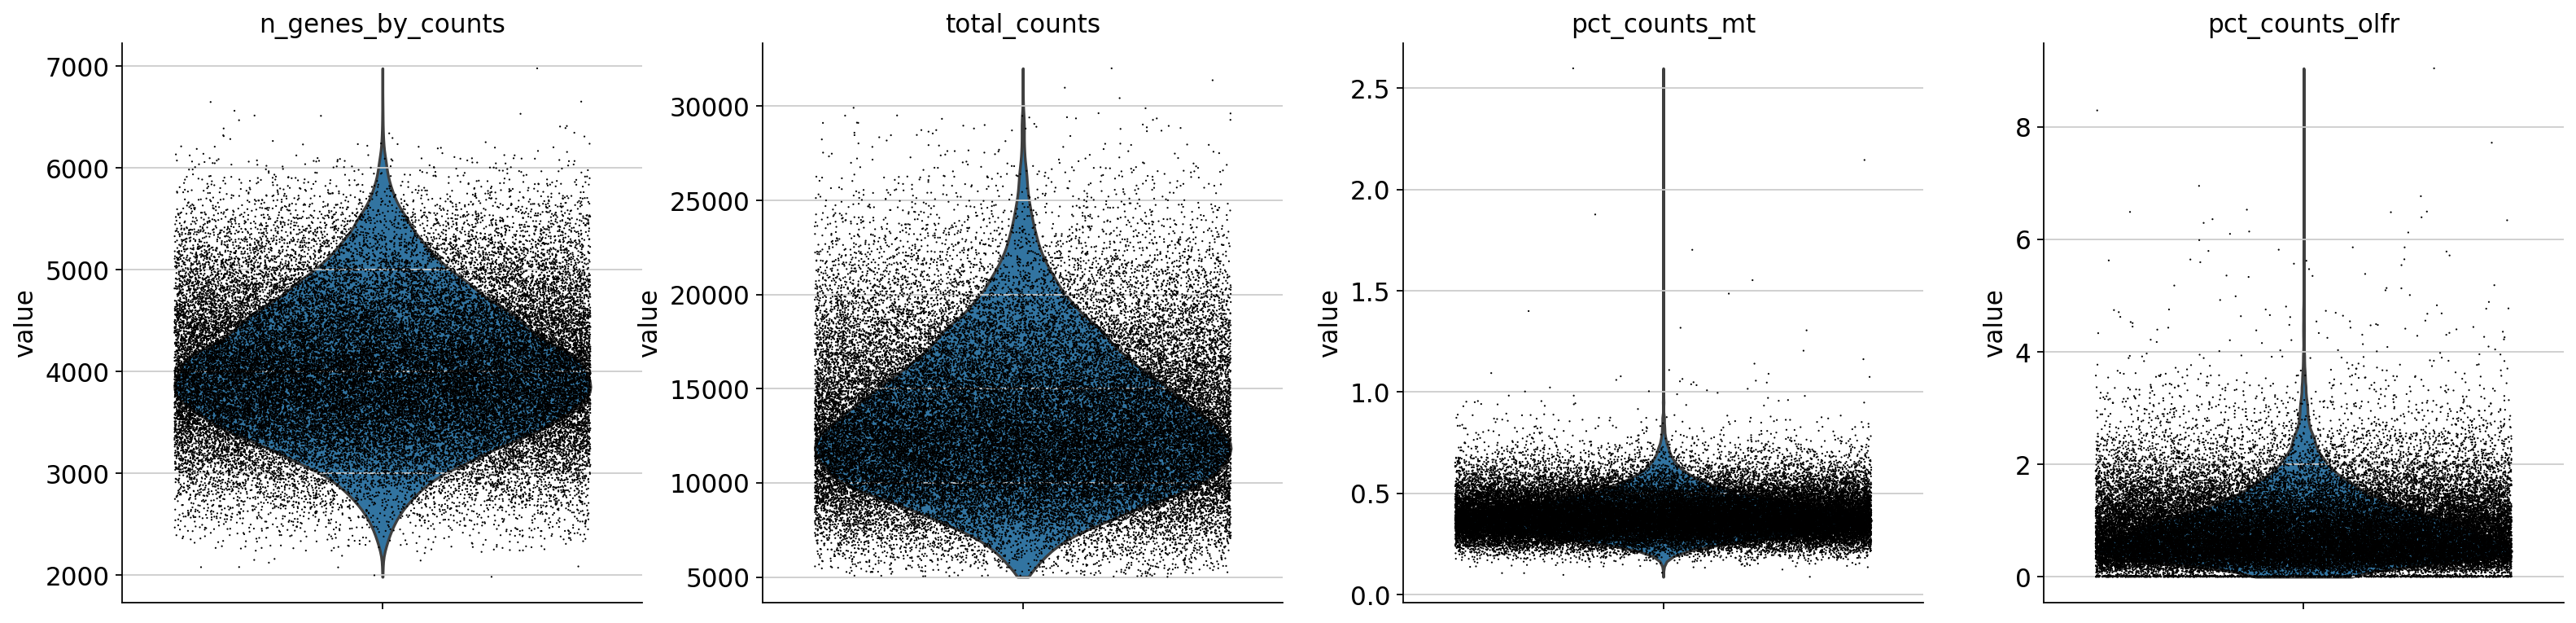

In [187]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_olfr'],
             jitter=0.4, multi_panel=True)

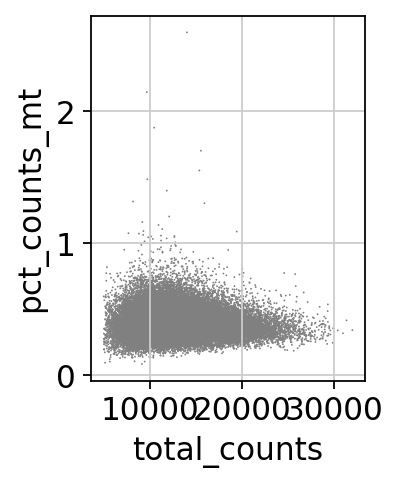

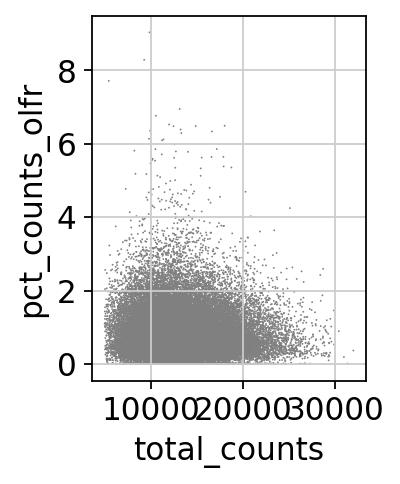

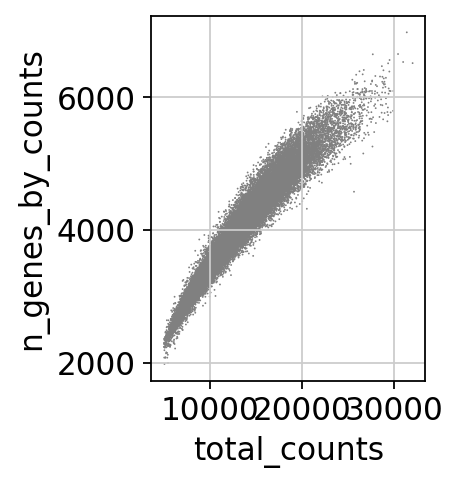

In [188]:
# visualize the cell counts corresponding to mt and oflr 
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_olfr')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [189]:
# remove cells with mt counts > 5
adata = adata[adata.obs.pct_counts_mt < 5, :]

/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:02)


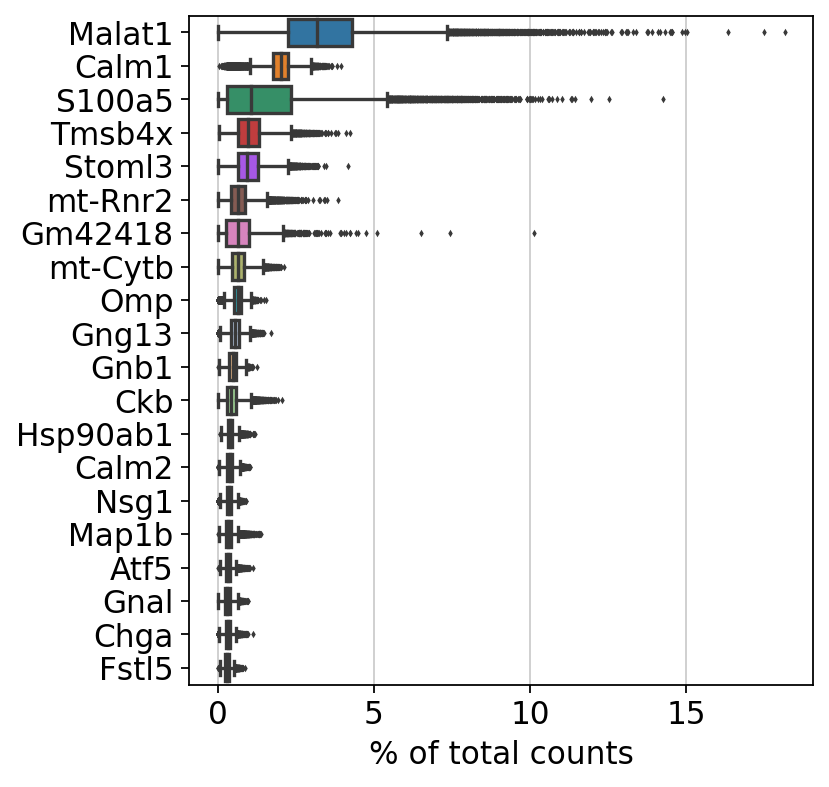

In [190]:
# visualize the top 20 variable gene
sc.pl.highest_expr_genes(adata, n_top=20)

In [191]:
# Define genes to be removed from the datasets prior to finding highly variable genes for clustering
mito_genes = adata.var_names.str.startswith('mt-')
olfr_genes = adata.var_names.str.startswith('Olfr')
malat1 = adata.var_names.str.startswith('Malat')

# Adds the True positions together for a remove list 
remove = np.add(mito_genes, olfr_genes)
remove = np.add(remove, malat1)
keep = np.invert(remove)

adata = adata[:,keep]
print(adata.n_obs, adata.n_vars)

44146 25408


In [192]:
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# logaritmize
sc.pp.log1p(adata)
# scale
# sc.pp.scale(adata)

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:22): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [193]:
# computer and filter data by highly_variabel_genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
# regress out total counts and mt pct 
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
# calculate pca 
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.draw_graph(adata)
# calculate umap 
sc.tl.umap(adata)
# adata.write('./GSE173947_home_cage_mOSN_iOSN.h5ad')

extracting highly variable genes
    finished (0:00:12)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']
    finished (0:01:12)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:06:31)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:23)


In [29]:
# adata = desc.read_h5ad('./GSE173947_home_cage_matureOSN.h5ad')
adata = desc.read_h5ad('./GSE173947_home_cage_mOSN_iOSN.h5ad')

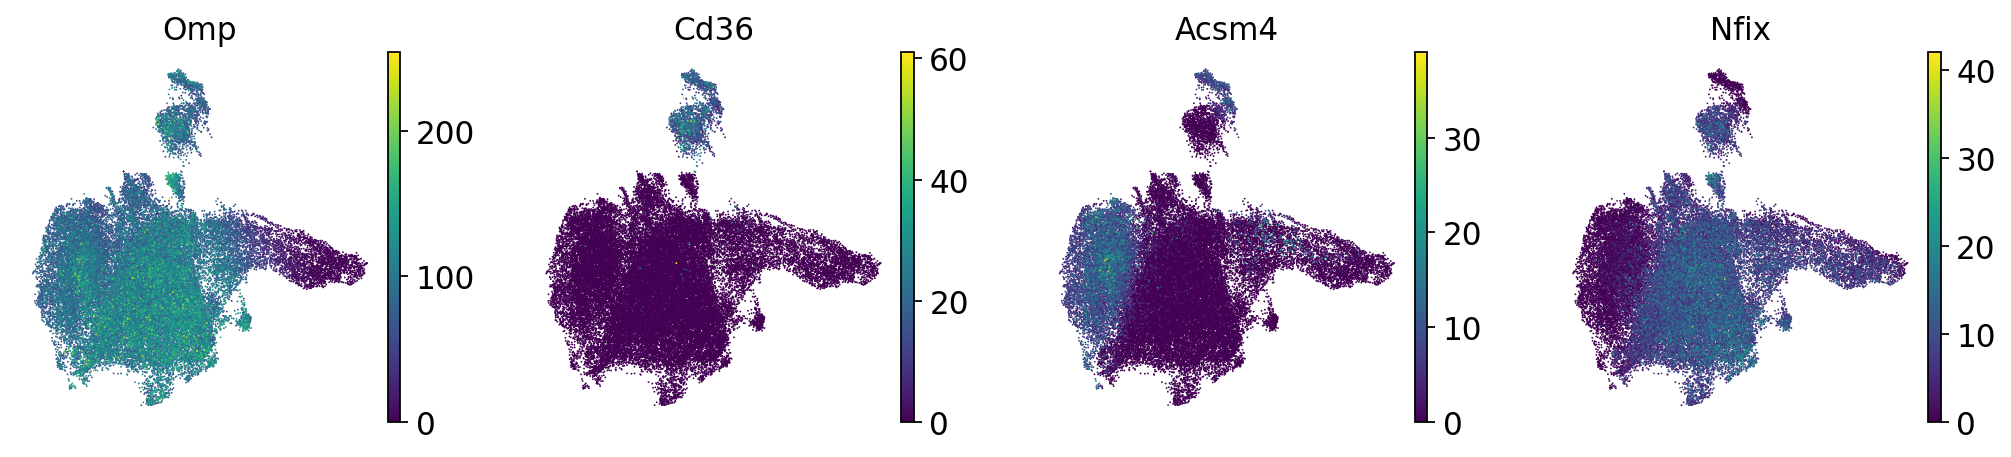

In [195]:
# confirming the umap is consistent with tsukahara et al. 
sc.pl.umap(adata, color=['Omp', 'Cd36','Acsm4','Nfix'])

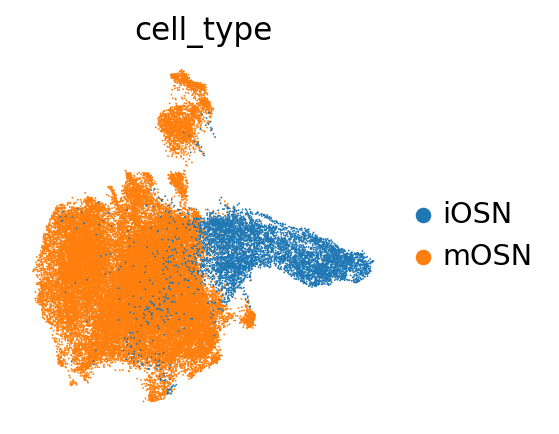

In [199]:
sc.pl.umap(adata, color=['cell_type'])

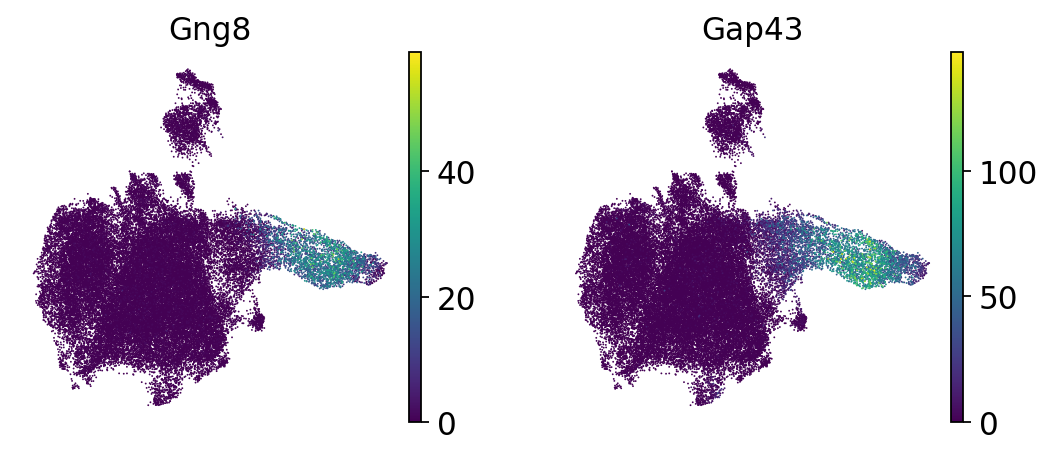

In [108]:
# immature (Gng8, Gap43) 
sc.pl.umap(adata, color=['Gng8', 'Gap43'])

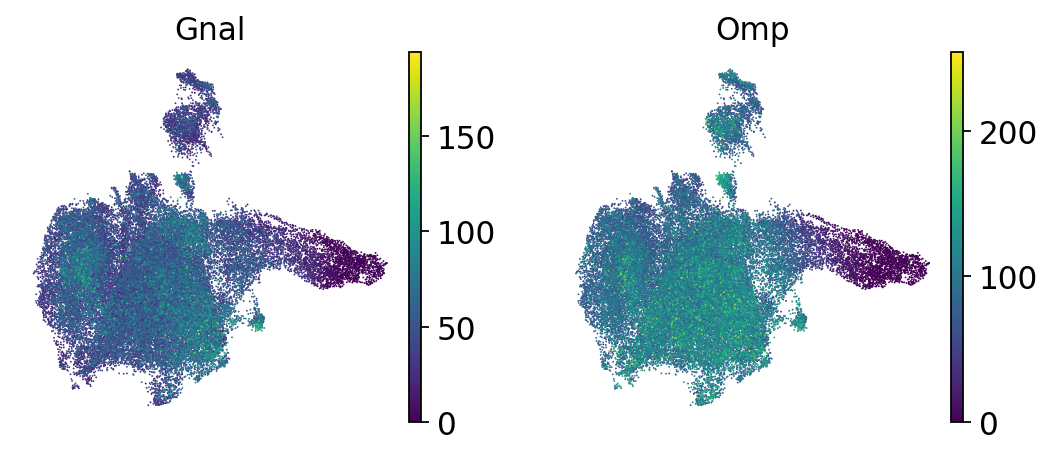

In [109]:
# mature (Gnal, Omp) 
sc.pl.umap(adata, color=['Gnal', 'Omp'])

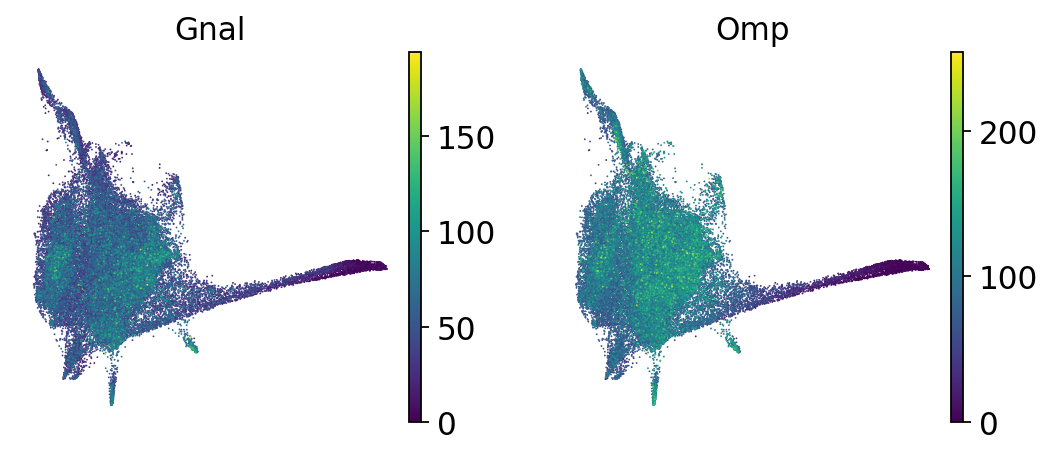

In [100]:
sc.pl.draw_graph(adata, color=['Gnal', 'Omp'])

In [270]:
# Clustering PAGA via leiden clustering method
sc.tl.leiden(adata, resolution = 0.5)
sc.tl.paga(adata, groups='leiden')

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:06)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


--> added 'pos', the PAGA positions (adata.uns['paga'])


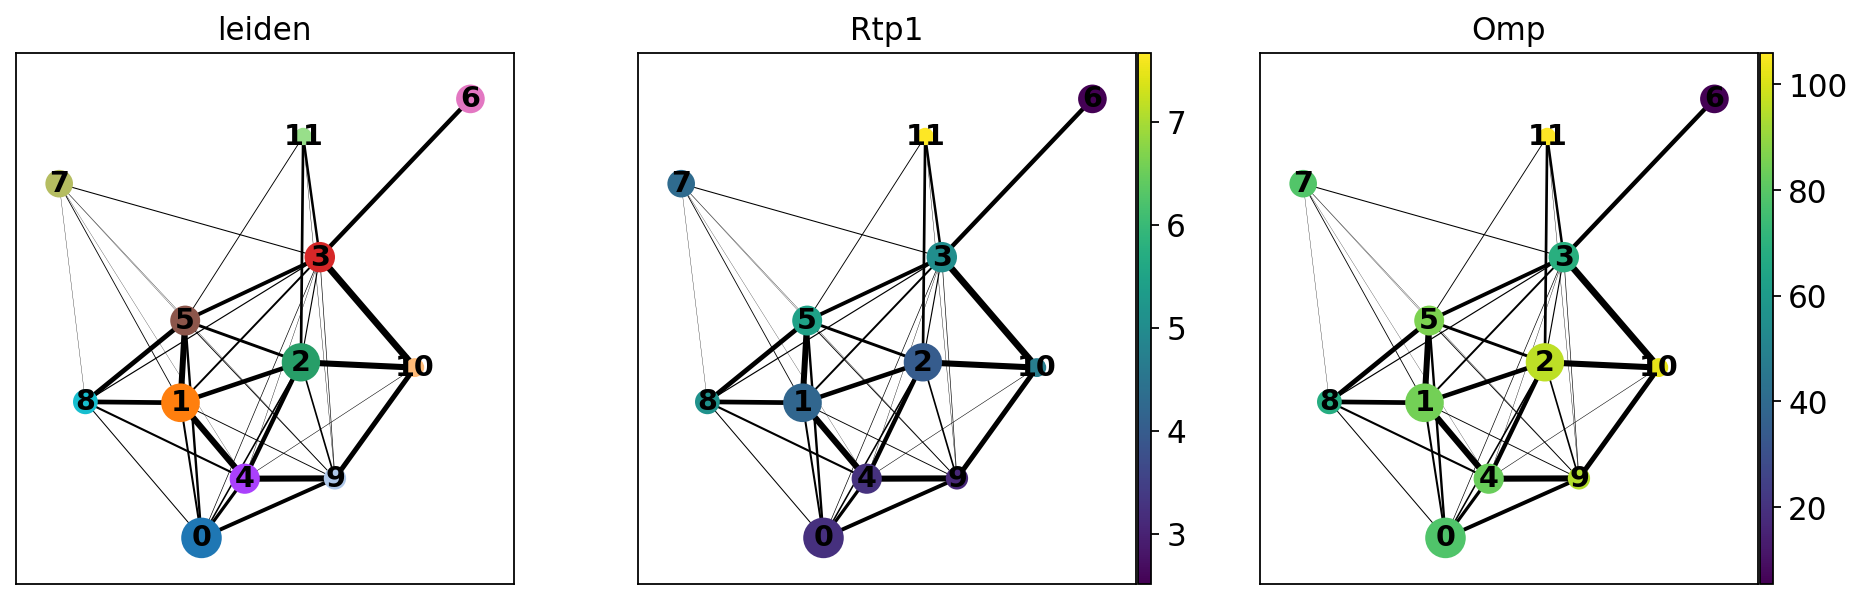

In [287]:
sc.pl.paga(adata, color=['leiden', 'Rtp1', 'Omp'])

In [205]:
sc.tl.draw_graph(adata, init_pos='paga')
# adata.write('./GSE173947_home_cage_mOSN_iOSN.h5ad')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:06:12)


In [ ]:
sc.set_figure_params()
sc.pl.draw_graph(adata, color=['leiden', 'Rtp1', 'cell_type'], legend_loc='on data')

In [305]:
# adata.write('./GSE173947_home_cage_mOSN_iOSN.h5ad')
adata = desc.read_h5ad('./files/GSE173947_home_cage_mOSN_iOSN.h5ad')

In [84]:
# Diffusion pseudotime (n_dcs = 10) was calculated in Scanpy 
# on the nearest neighbor graph (n_pcs = 10, n_neighbors = 10), 
# and normalized to the lowest pseudotime values of immature OSNs that had undergone OR choice and were expressing ORs.
adata.uns['iroot'] = np.flatnonzero(adata.obs['leiden']  == '6')[0]
sc.tl.dpt(adata, n_dcs=10)

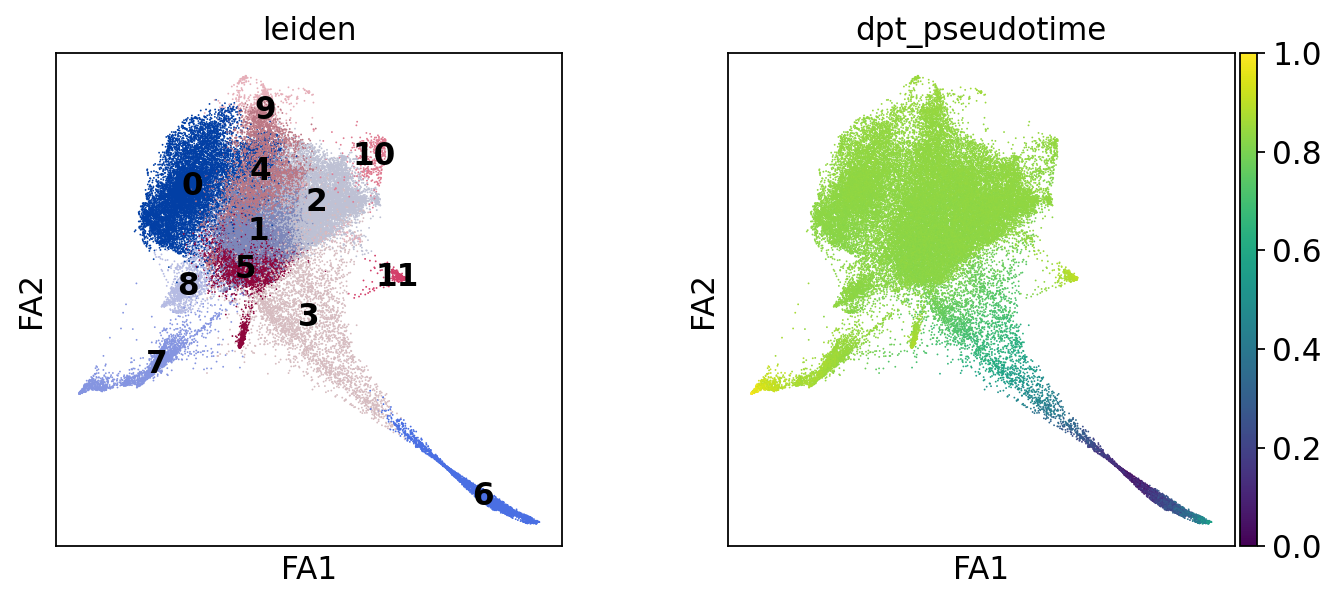

In [306]:
# sc.set_figure_params(figsize=['10','10'])
sc.set_figure_params()
sc.pl.draw_graph(adata, color=['leiden', 'dpt_pseudotime'], legend_loc='on data')

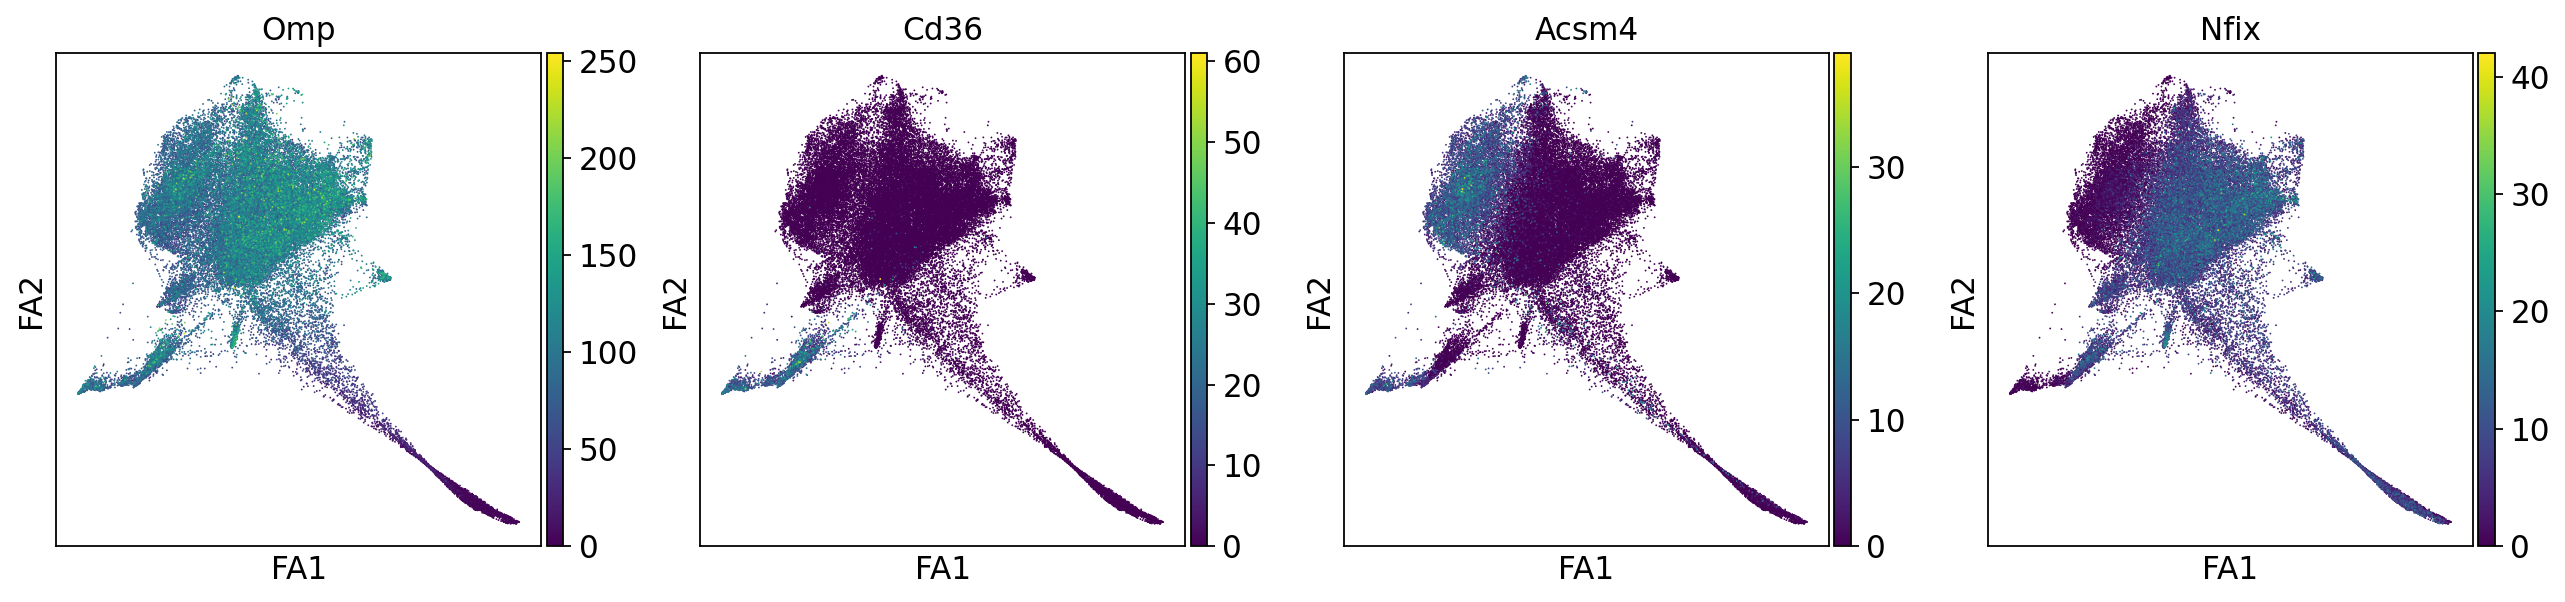

In [351]:
#  'Cd36'(Cd36+ OSN) 'Acsm4'(dorsal OSN),'Nfix'(ventral OSN) highlights the differnt sub OSN groups 
sc.pl.draw_graph(adata, color=['Omp', 'Cd36','Acsm4','Nfix'], legend_loc='on data')

In [ ]:
# extract top_olfr column from meta data join it with adata
meta_mOSN = pd.read_csv('./files/GSE173947_home_cage_metadata.csv')[['Unnamed: 0','top_Olfr']]
meta_mOSN.rename(columns={'Unnamed: 0':'index'}, inplace=True)
meta_iOSN = pd.read_csv('./files/GSE173947_home_cage_immature_metadata.csv')[['index','top_Olfr']]
meta_top_Olfr = pd.concat([meta_mOSN, meta_iOSN])
meta_top_Olfr = meta_top_Olfr.set_index('index')
# adds the meta_top_olfr column to the adata 
adata.obs = adata.obs.join(meta_top_Olfr)
# adata.write('./GSE173947_home_cage_mOSN_iOSN.h5ad')

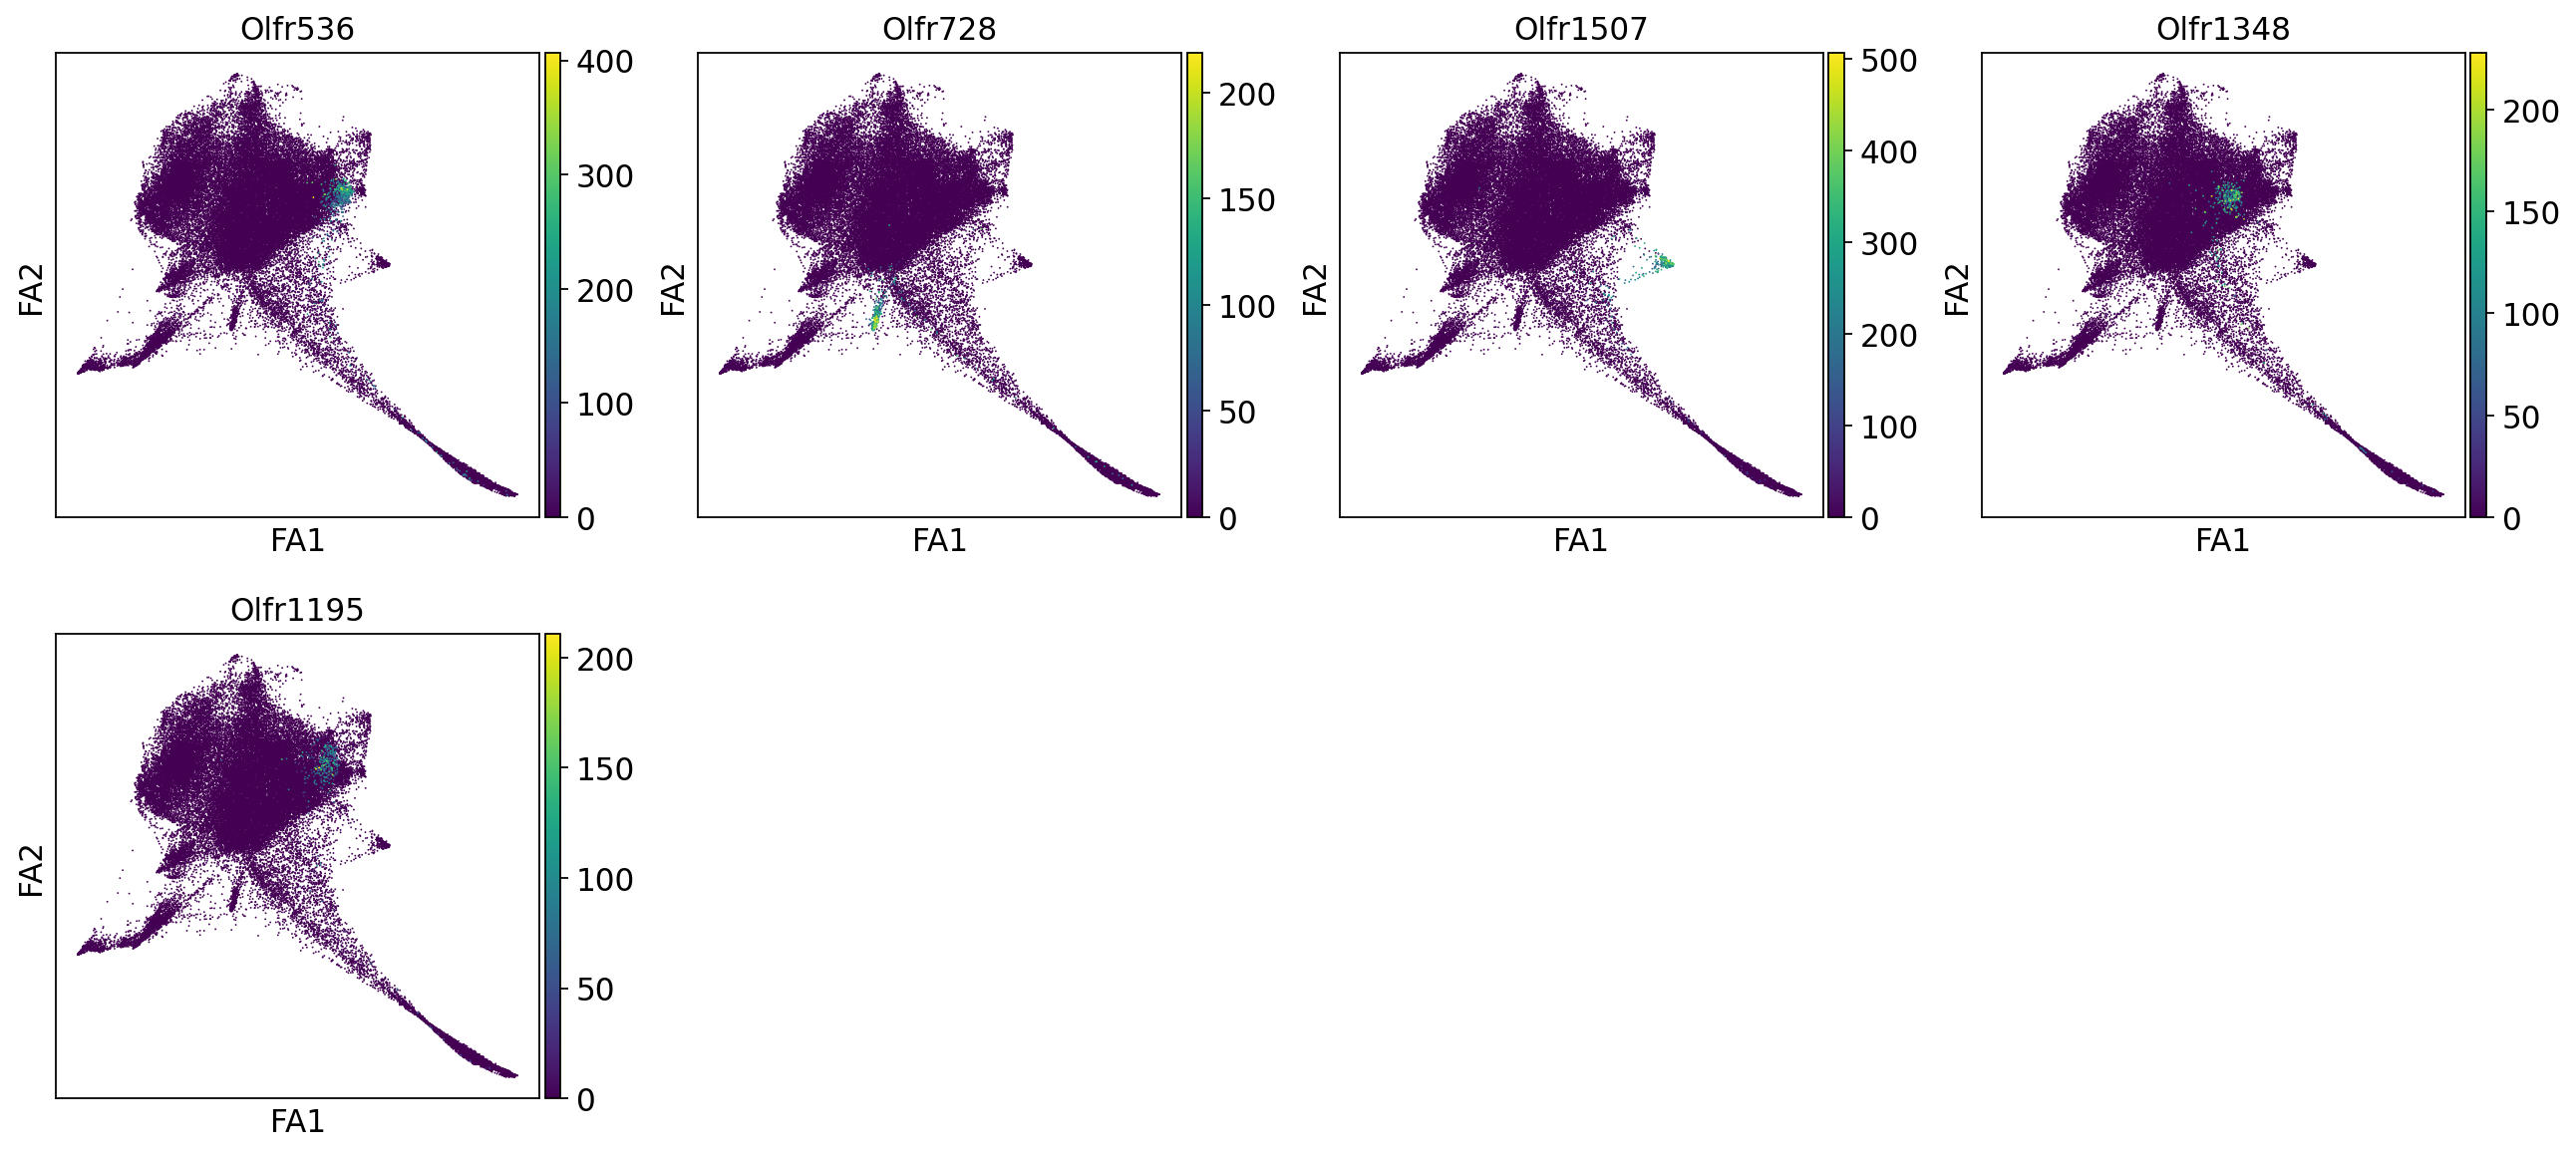

In [461]:
# prints top occuring Olfr
adata.obs['top_Olfr'].value_counts()
# visualize top_olfr clutsers / prints first 5 of top_Olfr 
sc.pl.draw_graph(adata, color=list(adata.obs['top_Olfr'].value_counts().index[:5]),
                 legend_loc='on data')

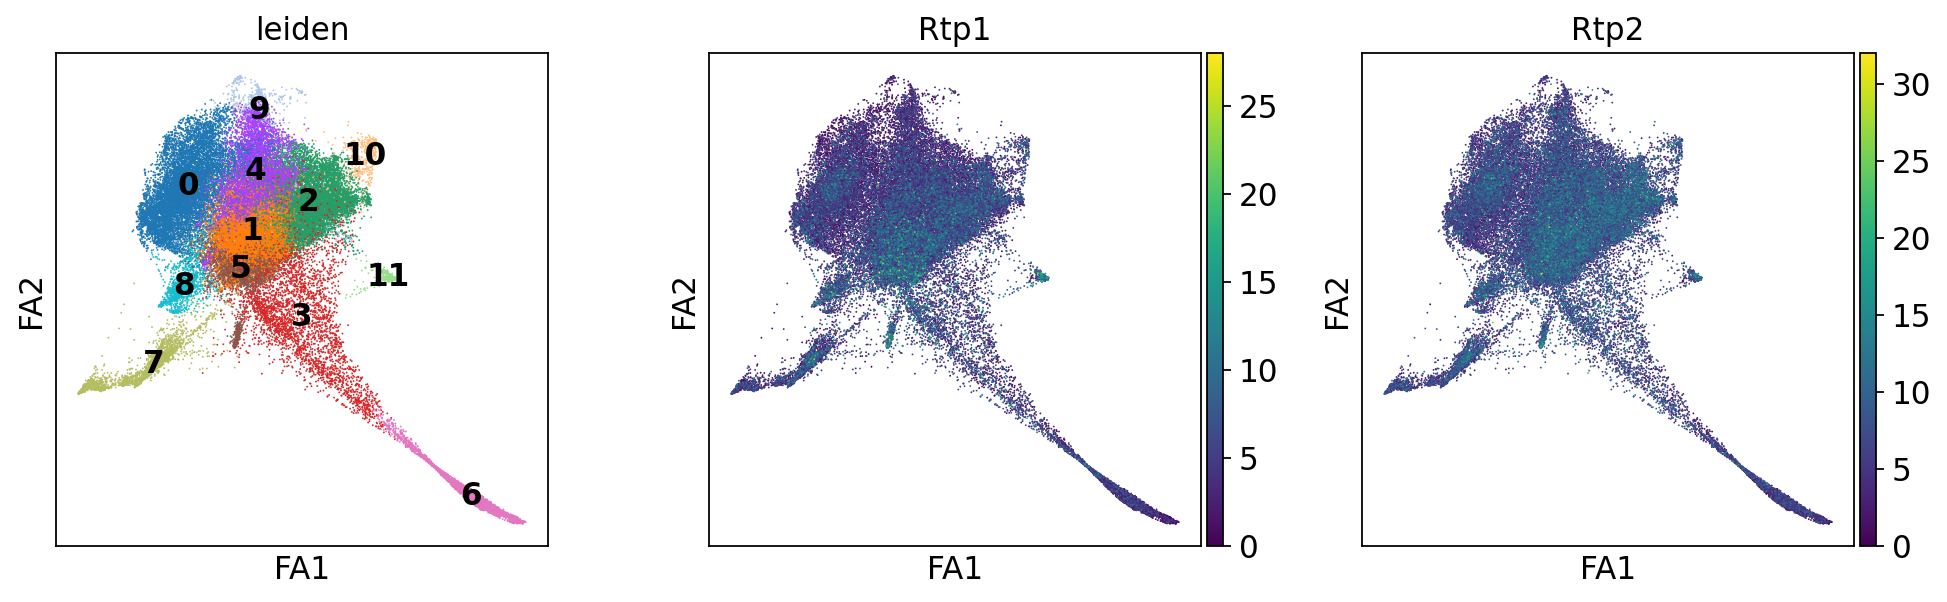

In [398]:
# adata.raw.var.index[np.where(adata.raw.var.index.str.contains('Rtp'))]
sc.set_figure_params(facecolor='White')
sc.pl.draw_graph(adata, color=['leiden', 'Rtp1', 'Rtp2'], legend_loc='on data')

In [ ]:
sc.set_figure_params(facecolor='White')
sc.pl.heatmap(adata, gene_names, groupby='leiden', cmap='viridis', dendrogram=False)


Contructs a raw table that's not filtered.
The idea is to output a line graph to show expression of genes across dpt_time ordered by Rtp1

Only perform on iOSNs. As mOSN doesn't project rtp1 pseudotime as it's saturated 

In [7]:
adata = desc.read_h5ad('./files/GSE173947_home_cage_mOSN_iOSN.h5ad')
iOSN_adata = adata[adata.obs.cell_type.isin(['iOSN']),:]

In [13]:
adata = adata.raw.to_adata()

In [17]:
sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# sc.pp.scale(adata)

In [19]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata, resolution = 1)
sc.tl.paga(adata, groups='leiden')

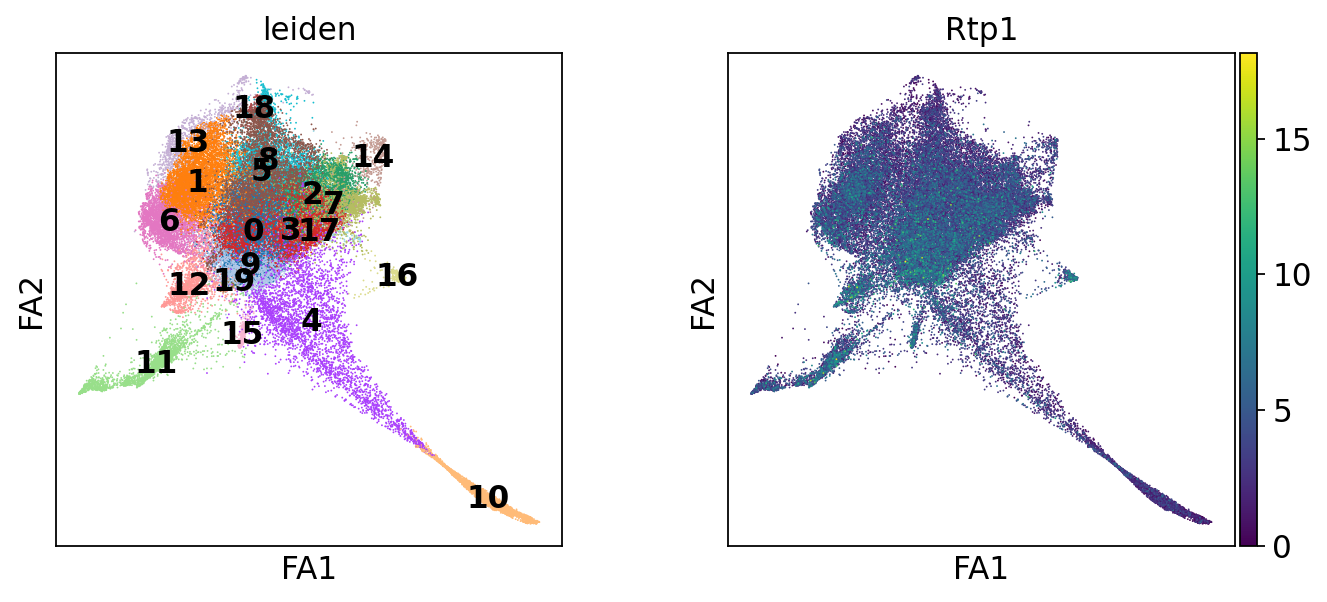

In [20]:
# Recluster with a higher resolution for more clusters to refine dpt resolution
sc.tl.leiden(adata, resolution = 0.8)
sc.tl.paga(adata, groups='leiden')
# Plot to visualize the starting leiden to calculate dpt
sc.set_figure_params()
sc.pl.draw_graph(adata, color=['leiden', 'Rtp1'], legend_loc='on data')

Clean up and remove the leidens that consists of lesser than 5 cells 

In [9]:
# Filters out clusters that have < 5 cells. As dpt calculation is inf if cell cluster < 2
rm_leiden = 'NA'
for cluster in iOSN_adata.obs.leiden.cat.categories:
    if bool(iOSN_adata[iOSN_adata.obs.leiden.isin([cluster]),:].shape[0] < 5): 
        if rm_leiden[0] == 'N':
            rm_leiden = iOSN_adata.obs.leiden.isin([cluster])
        else: 
            rm_leiden = np.add(rm_leiden, iOSN_adata.obs.leiden.isin([cluster]))
keep = np.invert(rm_leiden)
iOSN_adata = iOSN_adata[keep,:]

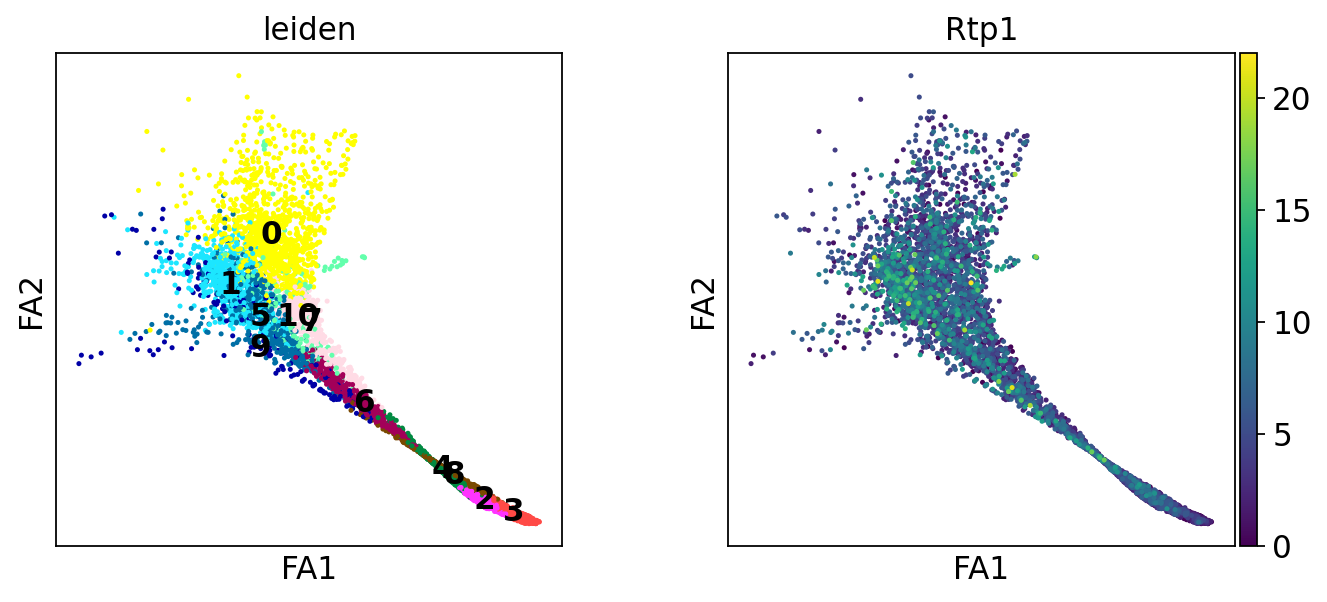

In [10]:
sc.pl.draw_graph(iOSN_adata, color=['leiden', 'Rtp1'], legend_loc='on data')

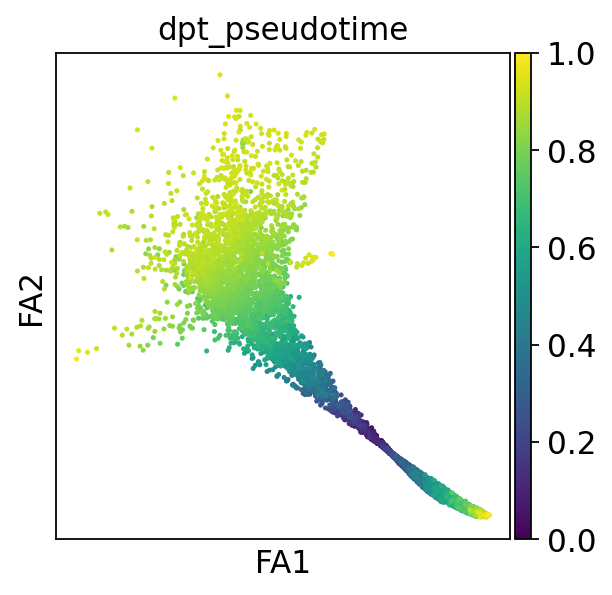

In [25]:
# Take the 'begining'cluster as visualized above and calculate dpt 
# begining cluster of interest should be where rtp1 expression is the lowest 
iOSN_adata.uns['iroot'] = np.flatnonzero(adata.obs['leiden']  == '3')[0]
sc.tl.dpt(iOSN_adata, n_dcs=10)
sc.pl.draw_graph(iOSN_adata, color=['dpt_pseudotime'], legend_loc='on data')

From the dpt analysis. We see that there are 2 separate maturations of cell cluster forming from he middle. Divide into two separate direction of cells for analysis 

In [8]:
# Subset data into two 
downward_iOSN_adata = iOSN_adata[iOSN_adata.obs.leiden.isin(['2','3','4','8'])]
upward_iOSN_adata = iOSN_adata[np.invert(iOSN_adata.obs.leiden.isin(['2','3','4','8']))]

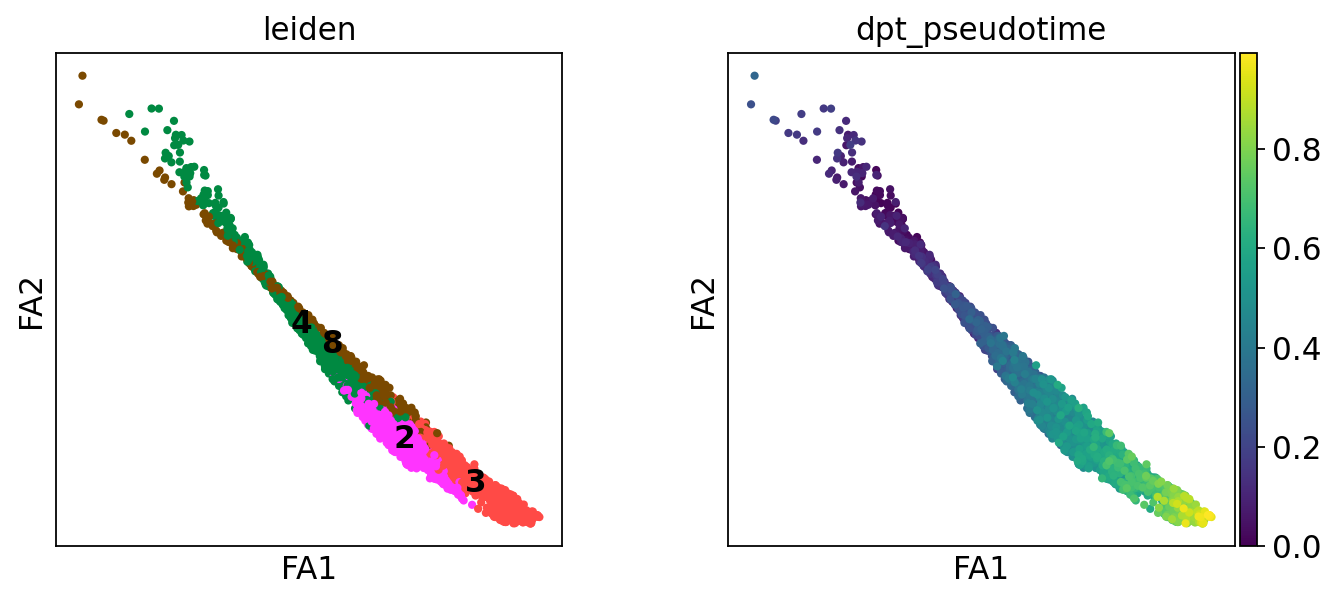

In [9]:
sc.set_figure_params(facecolor='white')
sc.pl.draw_graph(downward_iOSN_adata, 
                 color=['leiden', 'dpt_pseudotime'], legend_loc='on data')

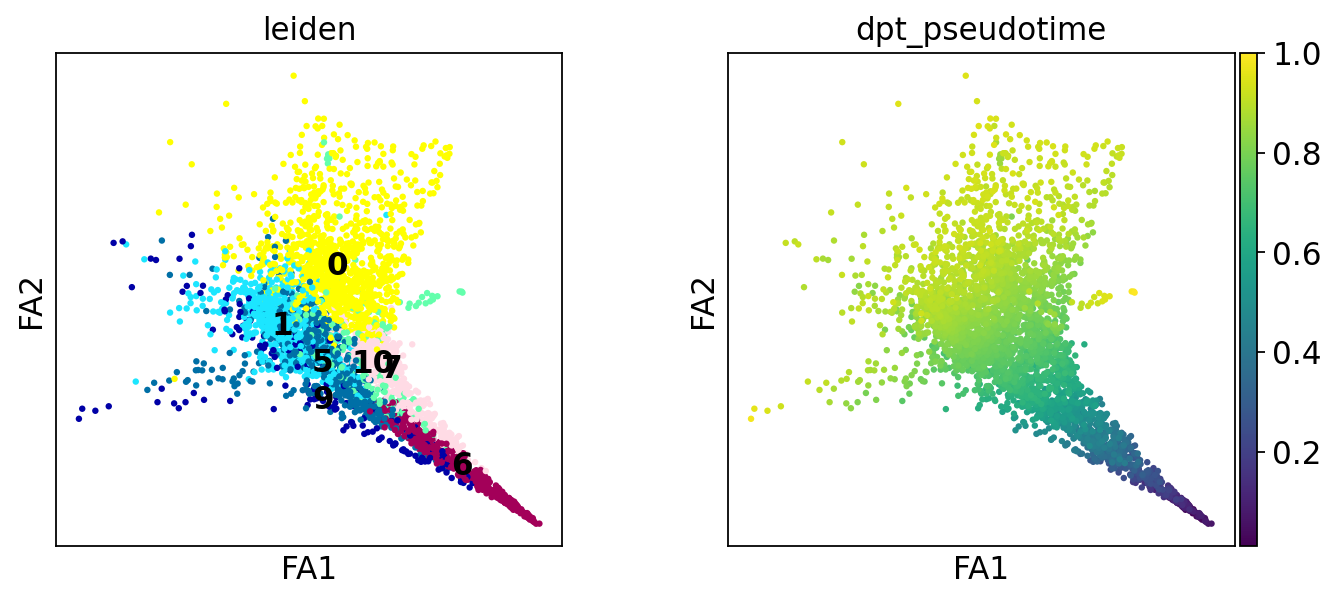

In [10]:
sc.pl.draw_graph(upward_iOSN_adata, 
                 color=['leiden', 'dpt_pseudotime'], legend_loc='on data')

Now that we have leiden and dpt information for each cell. Copy raw gene data onto the anndata in order normalize and scale to find the genes that are associated with Rtp1 expression 

In [11]:
# Construct a raw adata that's not filtered 
# rawadata = copy.deepcopy(iOSN_adata)
rawadata = iOSN_adata.raw.to_adata()
# normalize to depth 10 000
sc.pp.normalize_per_cell(rawadata, counts_per_cell_after=1e4)
# logaritmize
sc.pp.log1p(rawadata)
# scales the data 
sc.pp.scale(rawadata)
# rawadata.write('./GSE173947_dpt_raw.h5ad')

In [ ]:
# construct a gene_names of list of genes to include analysis
# exclude mt- , Rik ... etc 
rm_genes = rawadata.var_names.str.contains('Rik')
rm_genes = np.add(rm_genes, rawadata.var_names.str.startswith('mt-'))
rm_genes = np.add(rm_genes, rawadata.var_names.str.startswith('n-'))
rm_genes = np.add(rm_genes, rawadata.var_names.str.startswith('Olfr'))
rm_genes = np.add(rm_genes, rawadata.var_names.str.startswith('Gm'))
rm_genes = np.add(rm_genes, rawadata.var_names.str.startswith('AC'))
keep = np.invert(rm_genes)
gene_names = rawadata[:,keep].var_names

construct a pd dataframe for average gene expression and dpt_average across clusters 

In [13]:
# construct a pd dataframe for average gene expression of interest across clusters 
ge_table = pd.DataFrame(columns=gene_names, index=rawadata.obs['leiden'].cat.categories)                                                                                                 
dpt_average = pd.DataFrame(columns = ['dpt_average'], index = rawadata.obs['leiden'].cat.categories)
for clust in rawadata.obs.leiden.cat.categories: 
# for clust in ['2','3','4','8']: 
# for clust in ['0', '1', '5', '6', '7', '9', '10']:
#     following line subsets the adata by leiden AND subset from raw genes with gene_names. Then find mean across index(leiden)
    ge_table.loc[clust] = rawadata[rawadata.obs.leiden.isin([clust]),:][:,gene_names].X.mean(0)
    dpt_average.loc[clust] = rawadata.obs.iloc[np.where(rawadata.obs.leiden == clust)].dpt_pseudotime.mean()
ge_table = ge_table.join(dpt_average)

# assigns index as an column 
ge_table.reset_index(inplace=True)
# sort the rows by ascending value of Rtp1 expression 
ge_table.sort_values(by='Rtp1', inplace=True)
# ge_table.to_csv("./ge_table.csv")


Optional... To drop genes with smaller square difference of min-max than Rtp1 min-max 

In [157]:
# drop_gene = []
# # Drops genes that have smaller square difference between max and min expression than Rtp1 min-max
# for gene in gene_names:
#     if (ge_table[gene].min()**2 - ge_table[gene].max()**2) < (ge_table['Rtp1'].min()**2 - ge_table['Rtp1'].max()**2):
#         drop_gene += [gene]
# ge_table.drop(columns=drop_gene, inplace=True)

Function below goes through the gene expression table, and only removes genes that does not increase expression following the clusters of Rtp1 expression 

In [102]:
# # Creating control to test the loop 
# # ge_table['positive'] = [1,2,3,4,5,6,7,8,9,10,11,12]
# # ge_table['negative'] = [1,2,3,4,5,6,7,8,7,10,11,12]
# # # gene_names = gene_names.insert(0,'positive')
# # # gene_names = gene_names.insert(0,'negative')

# # for loop to filter out gene features that does not increase with Rtp1
# drop_gene = []
# for gene in gene_names:
#     previous = None
#     for cluster in ge_table.index:
# # comparing values between cluster 6,3,11 as this Rtp1 and dpt_average both ascends in this order
# #     for cluster in [6, 3, 5, 11]:
# #     for cluster in [6, 2, 3, 11]:
#         if previous == None: 
#             previous = ge_table[gene][cluster]        
#             continue
#         elif ge_table[gene][cluster] < previous: 
#             drop_gene += [gene]
#             break
#         else: 
#             previous = ge_table[gene][cluster]  
# ge_table = ge_table.drop(columns=drop_gene)

In [103]:
# # plot gene expression vs pseudotime line graph 
# # converts ge_table format dataframe into long datatable for plotting
# ge_data = pd.melt(ge_table, id_vars='index', value_vars=ge_table.columns,
#                  var_name='gene', value_name='expression')
# # plotting with plolty express
# fig = px.line(ge_data, x='index', y= 'expression', color='gene')
# fig.show()

Since no genes follow the same expression to cluster dpt_flow as Rtp1. 
Construct a ranking table instead and calculate the dpt differnce as a metric. 
Any gene between the ranking difference of sum(Rtp1 - Rtp2) ranking differnce is considerred associated with Rtp1. 

constructs rank table that holds dpt_average of each cluster sorted in increasing gene expression of the corresponding gene column

Only do on iOSN cells 

In [75]:
# Reading in ge_table from saved csv
# ge_table = pd.read_csv('./ge_table.csv')
# ge_table = csv_ge_table.iloc[:,1:]
# gene_names = ge_table.columns[1:len(ge_table.columns)-1]

In [ ]:
# Rank Table not used anymore, as it doesn't make sense to compare the sorted values based on individual genes, rather than the global sorted values based on Rtp1 
# rank_table = pd.DataFrame(columns=gene_names)   
# Constructs rank table that holds dpt_average of each cluster sorted in increasing gene expression of the corresponding gene column 
# for gene in gene_names: 
# #     Either keep dpt_value for MSE or expression 
# #     rank_table[gene] = ge_table[[gene, 'dpt_average']].sort_values(by=gene).dpt_average.reset_index(drop=True)
#     rank_table[gene] = ge_table[[gene, 'dpt_average']].sort_values(by=gene)[gene].reset_index(drop=True)
# print('rank_table constructed')

In [241]:
# list of genes to exclude exemption from being eliminated 
# Finds the manually exclude genes in the gene_names list 
excluded_genes = [x for x in gene_names if x in ['Omp','Cnga4','Ano2', 'Cnga2', 'Cngb1', 
                                                 'Stoml3', 'Stom', 'Rtp2', 'Clgn', 'Gnal', 'Gng13', 'Adcy3','Ric8b'
                                                ]]
# These are mature OSN markers 

In [135]:
gene_names = np.intersect1d(ge_table.columns, gene_names)
mse_table = pd.DataFrame(columns=gene_names, index=['mse'])    
# Calculate mean squared error of dpt_average in respect to Rtp1
for gene in gene_names:
    mse_table[gene] = mean_squared_error(ge_table[gene],ge_table['Rtp1'])    
print('mse_table constructed')

drop_gene = []
# Filter for genes that have smaller mse than Rtp2 - Rtp1. These are defined as associated to Rtp1
for gene in mse_table.columns:
    if not gene in excluded_genes:
        if (mse_table[gene] > mse_table['Rtp2']).bool():
            drop_gene += [gene]
mse_table.drop(columns=drop_gene, inplace=True)
print(len(drop_gene), 'genes dropped from mse_table')
# mse_table.to_csv("./mse_table.csv")

mse_table constructed
15712 genes dropped from mse_table


Filter gene expression table with the found associated genes. And check for gene expression across leidens in order of increase Rtp1 expression

Since the clusters doesn't accurately depict the dpt_pseudotime spread. 
Bin dpt by ranges for each individual cells instead of by cluster 
0 - 0.2, 0.2 - 0.4 ......

In [32]:
# adata = desc.read_h5ad('./files/GSE173947_home_cage_mOSN_iOSN.h5ad')
iOSN_adata = adata[adata.obs.cell_type.isin(['iOSN']),:]

In [5]:
# Recluster with a higher resolution for more clusters to refine dpt resolution
sc.tl.leiden(iOSN_adata, resolution = 0.8)
sc.tl.paga(iOSN_adata, groups='leiden')
# Filters out clusters that have < 5 cells. As dpt calculation is inf if cell cluster < 2
rm_leiden = 'NA'
for cluster in iOSN_adata.obs.leiden.cat.categories:
    if bool(iOSN_adata[iOSN_adata.obs.leiden.isin([cluster]),:].shape[0] < 5): 
        if rm_leiden[0] == 'N':
            rm_leiden = iOSN_adata.obs.leiden.isin([cluster])
        else: 
            rm_leiden = np.add(rm_leiden, iOSN_adata.obs.leiden.isin([cluster]))
keep = np.invert(rm_leiden)
iOSN_adata = iOSN_adata[keep,:]

Trying to set attribute `.obs` of view, copying.


In [33]:
# Run to use only normalized raw counts 
iOSN_adata = iOSN_adata.raw.to_adata()
sc.pp.normalize_total(iOSN_adata, target_sum=1e4)

In [34]:
sc.pp.neighbors(iOSN_adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(iOSN_adata, resolution = 1)
sc.tl.paga(iOSN_adata, groups='leiden')

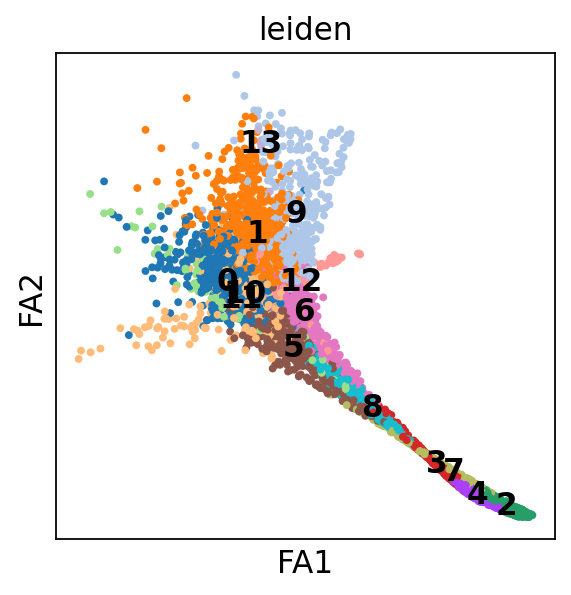

In [35]:
sc.set_figure_params(facecolor='white')
sc.pl.draw_graph(iOSN_adata, color=['leiden'], legend_loc='on data', size=50)

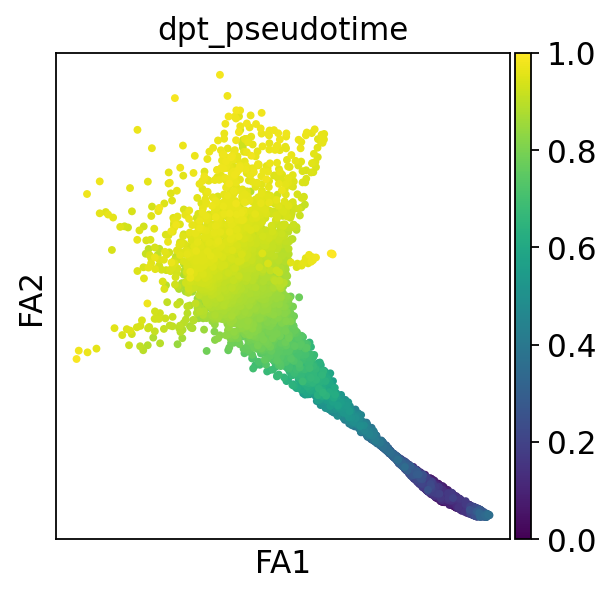

In [36]:
iOSN_adata.uns['iroot'] = np.flatnonzero(iOSN_adata.obs['leiden']  == '2')[0]
sc.tl.dpt(iOSN_adata)
sc.pl.draw_graph(iOSN_adata, color=['dpt_pseudotime'], legend_loc='on data', size=50)

Construct a new ge_table with cells binned together by dpt value cutoffs rather than umap clusters 

In [37]:
# subsets the adata. so it only contains the upward trajectory cells 
iOSN_adata = iOSN_adata[np.invert(iOSN_adata.obs.leiden.isin(['2','3','4','7']))]   
# Creates a column of dpt_bins to group cells by 
iOSN_adata.obs['dpt_bins'] = None 
for dpt_cutoff in np.linspace(1,0, num = 11):
    iOSN_adata.obs.loc[iOSN_adata.obs.dpt_pseudotime < dpt_cutoff, 'dpt_bins'] = str(abs(round(dpt_cutoff-0.1,1))) +"-"+ str(round(dpt_cutoff,1))

Trying to set attribute `.obs` of view, copying.


/data/jlu/anaconda3/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dpt_bins' as categorical


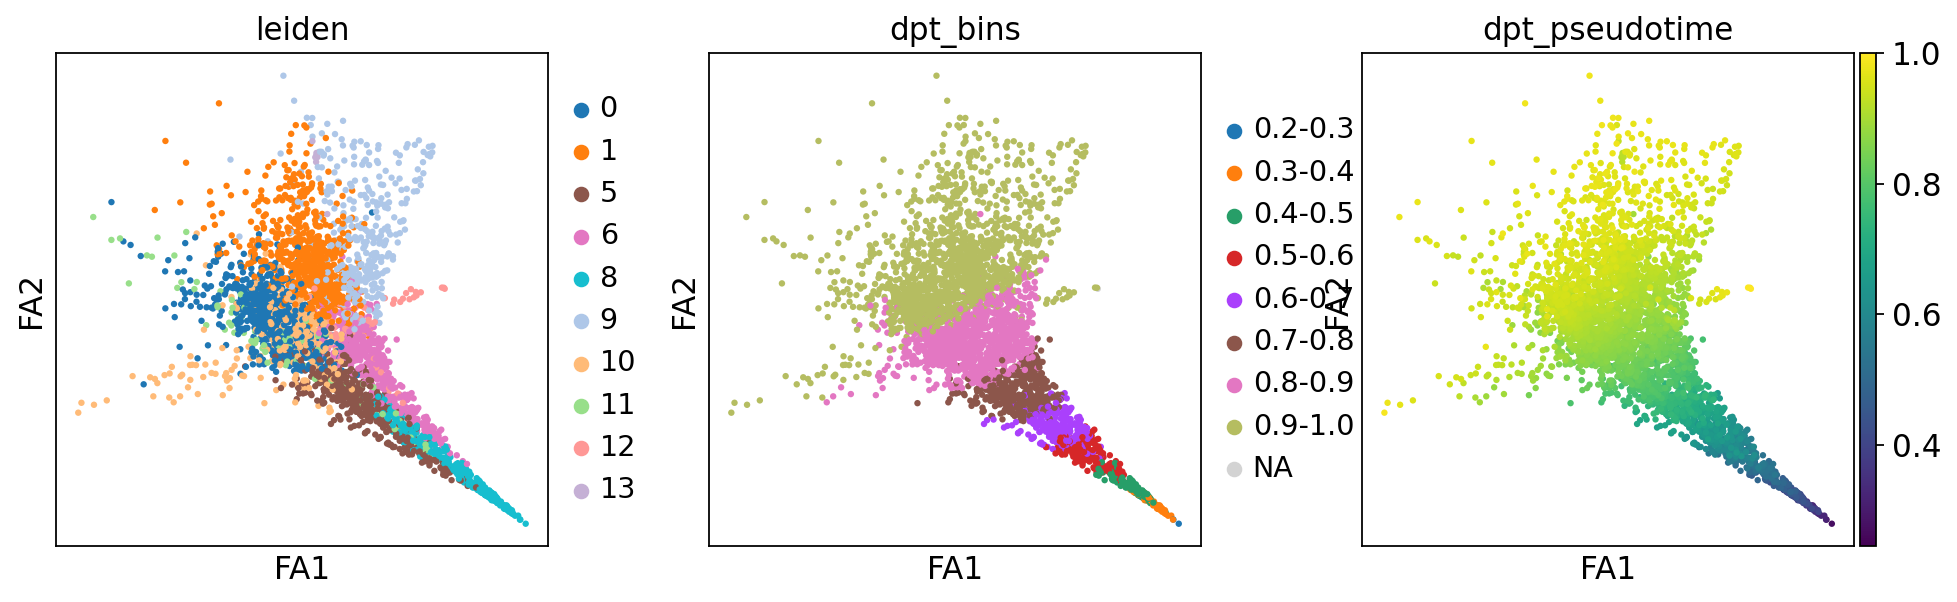

In [38]:
sc.set_figure_params(facecolor='White')
sc.pl.draw_graph(iOSN_adata, 
                 color=['leiden','dpt_bins', 'dpt_pseudotime']
#                  , legend_loc='on data'
                )

In [40]:
from importlib import reload 
import GE_functions
reload( GE_functions )

<module 'GE_functions' from '/data/jlu/scSeq_tsukahara/GE_functions.py'>

In [43]:
# ge_table = pd.read_csv('./output/tsukahara/ge_table_dpt_bin.csv')
# ge_table.rename(columns={'Unnamed: 0':'index'}, inplace=True)
# ge_table.drop(["Unnamed: 0"], axis = 1, inplace = True)
# ge_table.set_index("index", inplace = True)

In [41]:
gene_names = GE_functions.get_gene_names(iOSN_adata)
excluded_genes = GE_functions.get_excluded_genes(gene_names)

In [46]:
# generate and filter mse table for plotting 
# relative to rtp1
ge_table = GE_functions.get_ge_table(iOSN_adata, gene_names)
mse_table = GE_functions.get_mse_table(ge_table, gene_names)
mse_table.transpose().sort_values('mse')[0:100].to_csv('./output/tsukahara/MSE_genes_Rtp1_top100_mOSN_iOSN_ONLYnormalized.csv')
mse_table = GE_functions.filter_mse_table(mse_table, excluded_genes)

mse_table constructed
14841 genes dropped from mse_table


In [71]:
# line below quickly sorts through the mse_table to find the order rank of desired gene if not in the top 100 csv 
# [i for i, x in enumerate(mse_table.columns == 'Clgn') if x]

[2640]

In [ ]:
# saving line plot as html
fig = GE_functions.expression_line_plot(ge_table, mse_table)
fig = fig.update_layout(title = 'Average gene expression change across dpt bins (ONLY normalized counts) \n Data from tsukahara mOSN/iOSN homecage')
fig.write_html("./output/tsukahara/ge_line_dpt_bin_Rtp1_ONLYnormalized.html")
fig

In [48]:
# relative to rtp2
mse_table = GE_functions.get_mse_table(ge_table, gene_names, mse_gene='Rtp2')
mse_table.transpose().sort_values('mse')[0:100].to_csv('./output/tsukahara/MSE_genes_Rtp2_top100_mOSN_iOSN_ONLYnormalized.csv')
mse_table = GE_functions.filter_mse_table(mse_table, excluded_genes, mse_gene='Rtp1')

mse_table constructed
14965 genes dropped from mse_table


In [ ]:
# saving line plot as html
fig = GE_functions.expression_line_plot(ge_table, mse_table)
fig = fig.update_layout(title = 'Average gene expression change across dpt bins relative Rtp2 (ONLYnormalized counts)\n Data from tsukahara mOSN/iOSN homecage')
fig.write_html("./output/tsukahara/ge_line_dpt_bin_Rtp2_ONLYnormalized.html")
fig

In [245]:
sc.tl.rank_genes_groups(iOSN_adata, 'dpt_bins', method='t-test')
# d_top_markers = pd.DataFrame(iOSN_adata.uns['rank_genes_groups']['names']).head(5)
# d_top_markers

In [254]:
dpt_bins_top_markers = pd.DataFrame(iOSN_adata.uns['rank_genes_groups']['names']).head(100)
# dpt_bins_top_markers.to_csv('./dpt_bins_top_markers.csv')
dpt_bins_top_markers

0.1-0.2        0.2-0.3  0.3-0.4        0.4-0.5  0.5-0.6        0.6-0.7  \
0   Arhgdig        Arhgdig  Arhgdig          Stmn2    Calb2          Calb2   
1     Tubb5          Gap43   Tmsb10        Arhgdig    Gap43          Prrg2   
2    Tmsb10          Stmn2     Gng8         Tmsb10   Stk32a          Kif5c   
3      Gng8         Tmsb10    Stmn2          Calb2    Stmn2       Trappc2l   
4    Dpysl3           Gng8    Gap43          Gap43   Tmsb10           Txn1   
..      ...            ...      ...            ...      ...            ...   
95    Ncbp2           Ebf1   Sec61b           Bzw2   Spock1          Ncam1   
96    Cpeb1  2810025M15Rik    Hmgn1          Srsf2    Rpl34  2210016L21Rik   
97    Ddah2          Rpl13    Srsf7           Rps8  Fam171b         Agpat4   
98    Dctn2          Rps11      Jup           Ttc3    Rps16         Tagln3   
99   Zfp664          Rps18  Hsp90b1  4930578M01Rik    Hecw1           Pmm1   

   0.7-0.8        0.8-0.9  
0    Atox1            Omp  
1      Omp         Tspan7  
2     Chga  1700012B09Rik  
3   Umodl1          Adcy3  
4    Calm1         Stoml3  
..     ...            ...  
95  Ndufc2         Slc8a1  
96  Gpr162          Magi1  
97   Ikzf2           Gpi1  
98   Enkur          Ttc25  
99  Tmsb4x        Tmem159  

[100 rows x 8 columns]